# 프로젝트 시작


이번사용할 데이터는 캐글의 Chest X-Ray Images 이다.      
폴더를 생성하고 캐글에서 데이터를 다운받아주세요.    
https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
```
$ mkdir -p ~/aiffel/chest_xray
$ cd ~/Downloads && unzip archive.zip -d ~/aiffel
```
위와 같이 압축을 풀고 나면, 데이터의 구성은 ~/aiffel/chest_xray 하위에 3개의 폴더 (train, test, val)로 구성되며, 각 이미지 카테고리 (폐렴 / 정상)에 대한 하위 폴더를 포함합니다. 5,856 개의 X-Ray 이미지 (JPEG)와 2 개의 범주 (폐렴 / 정상)가 있습니다. 전체 데이터의 크기는 총 1.2GB 가량 됩니다.


# 14. 프로젝트 : 폐렴 진단기 성능개선
좀전까지 우리는 대략 80% 정도의 정확도를 가진 X-RAY 사진 판독 폐렴 진단기를 만들어 보았습니다.

하지만 숙련된 의사분들은 90% 이상에 도달한다고 하니, 좀더 분발해야겠죠?

그렇다면 우리는 좀전까지의 실습 과정을 되짚어보면서, 어떤 점을 좀더 개선해볼 수 있을지 따져 보고 스스로 개선해 가면서 좀더 성능을 향상시켜 보려고 합니다.

# Step 1. 실험환경 Set-up

## 라이브러리 설치

In [34]:
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지

## Batch size, Epoch 등을 변경해볼 수 있다.

In [35]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
# 16-> 32

#BATCH_SIZE = 16
BATCH_SIZE = 32

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
# 25 -> 50
#EPOCHS = 25
EPOCHS = 25
print(ROOT_PATH)

/home/aiffel-dj60/aiffel


# Step 2. 데이터 준비하기

## 데이터 가져오기

다운로드 받은 데이터는 3개의 데이터가 존재한다.
```
train               ->    5216개 
val(validation)     ->    624개
test                ->    16개

갯수 비는 89%, 10.7%, 0.3% 입니다.
train와 val데이터 합친후 다시 분리하자

```

In [36]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))
print('train_filenames의 타입',type(train_filenames))

5216
624
16
train_filenames의 타입 <class 'list'>


## train와 val데이터 합친후 다시 분리하기



### train,val 출력

In [37]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))

# train, test(val) dataset으로 분할. test_size에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames))
print(len(val_filenames))
#print(train_filenames)

4185
1047


### train의 Normal와 Pneumonia 데이터 개수

- 1:3으로 트레인데이터가 불균형(imbalance)하다. 이렇게 한 방향으로 쏠릴경우 학습이 잘 되지 않을 수 있다.

- test데이터와 val데이터는 학습과 관련 없기때문에 불균형(imalance)해도 된다.


In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1085
Pneumonia images count in training set: 3100


### tf.data 인스턴스를 만들기

In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
print(type(train_list_ds))
print(train_list_ds)

<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<TensorSliceDataset shapes: (), types: tf.string>


### Train 데이터 셋, validation 데이터 셋 갯수 확인

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))


Training images count: 4185
Validating images count: 1047


### 라벨 이름들을 한번 확인
```
정상을 의미하는 'NORMAL', 
폐렴을 의미하는 'PNEUMONIA'
```

In [9]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

['PNEUMONIA' 'NORMAL']


### 라벨 데이터 만들어주는 함수

In [10]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.

### 이미지 사이즈 통일 함수
이미지 데이터는 현실적으로 사이즈가 제각각일 가능성이 높습니다. 이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄여봅시다. decode_img 함수

In [11]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

## process_path 함수
- 이미지 사이즈 통일 함수get_label(file_path)사용

decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경합니다.

- 라벨 데이터 만들어주는 함수 decode_img(img)사용

get_label을 이용해서 라벨 값을 가져옵니다.

In [12]:
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

## train 데이터 셋과 validation 데이터 셋 만들기
num_parallel_calls 파라미터에서 set-up에서 초기화 한 AUTOTUNE을 이용하면 더욱 빠르게 데이터를 처리해줍니다.

In [13]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

## 이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인
- train_ds.take(1)은 하나의 데이터만 가져온다 라는 의미

In [14]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())


Image shape:  (180, 180, 3)
Label:  True


## 테스트 셋도 확인해보기

In [15]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


## augmentation 기법
 - 의료영상인 경우, 일반적인 이미지처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없다.
 - X-RAY 같은 의료영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있다.
 - augmentation 도입은 신중해야 한다.

만약 예를 들어 좌우반전 정도의 augmentation만 도입한다고 한다면 다음과 같이 진행될 것입니다.

In [16]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

## prepare_for_training() 함수 
-  prepare_for_training() 함수는 학습 데이터를 효율적으로 할 수 있도록 데이터를 변환해준다.
- Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해준다.

###  tf.data 파이프라인
#### shuffle()
- shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택합니다.

#### repeat() 
- repeat()를 사용하면 epoch를 진행하면서 여러번 데이터셋을 불러오게 돤다.이때 repeat()를 사용한 데이터셋의 경우 여러번 데이터셋을 사용할 수 있게 해줍니다.
ex) 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 됩니다. repeat()를 사용하면 자동으로 데이터를 맞춰준다.

#### batch() 
- batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어집니다.
ex) 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉜다.

#### prefetch() 
- prefetch()를 사용하면 학습데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄인다.

In [17]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# Step 3. 데이터 시각화
- 데이터를 보기 위해 먼저, train에 있는 batch 중 첫 번째 배치를 추출합니다. 추출된 배치를 image와 label 데이터 셋으로 나눕니다. 이제 show_batch()함수를 이용해서 결과 사진을 보겠습니다.
- 만약 augmentation을 시도하여 show_batch() 함수를 통해 실제로 좌우반전 되었다.


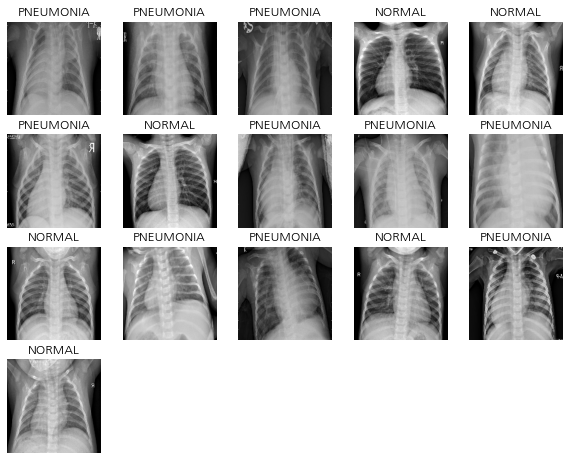

In [18]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

# Step 4. CNN 모델링
 Convolution filter, 채널 개수, activation, 모델구조 등을 다양하게 바꾸어볼 수 있다.

그리고, 우리는 BatchNormalization과 Dropout을 한 모델 안에서 동시에 사용하는 특이한 구성을 실습했습니다.
이것은 일반적으로 잘 사용되는 형태는 아닙니다. 하지만 이미지 사이즈가 크고 데이터가 부족한 의료영상에서는 실용적으로 간혹 좋은 성능을 보이기도 합니다. 만약 이 구성을 변경해 보면 어떤 효과가 발생하는지도 실험해 봅시다. BatchNormalization을 쓰거나 혹은 쓰지 않거나, Dropout을 쓰거나 혹은 쓰지 않거나 할 수 있습니다. 또, Dropout 비율을 변경해볼 수도 있습니다.

### conv_block

In [19]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

### Dense Block

In [20]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

### build_model

In [22]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# Step 5. 데이터 imbalance 처리
실습코드에서 데이터의 imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 class_weight를 설정해 주었습니다. 만약 이러한 처리를 생략한다면 어떻게 될까요? 또 recall을 강조하기 위해 폐렴데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 수는 없을까요?

In [23]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.93
Weight for class 1: 0.68


# Step 6. 모델 훈련
loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려해볼 수 있을 것입니다.



이미지 훈련은 GPU를 사용할 것이기 때문에 먼저 GPU를 선택합니다. 모델은 위에서 만들었던 모델 함수인 build_model()을 model에 선언합니다.

이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용합니다. optimizer로 'adam'을 사용합니다.
성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용합니다.

In [30]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

### 모델 fit 
각 파라미터에 위에서 선언했었던 변수, 데이터 셋을 가져와서 각각에 맞게 넣어준다.

In [31]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
130/130 [==============================] - 108s 828ms/step - loss: 0.4023 - accuracy: 0.8002 - precision: 0.9510 - recall: 0.7697 - val_loss: 0.6018 - val_accuracy: 0.7480 - val_precision: 0.7480 - val_recall: 1.0000
Epoch 2/25
130/130 [==============================] - 108s 832ms/step - loss: 0.2326 - accuracy: 0.9166 - precision: 0.9724 - recall: 0.9135 - val_loss: 0.7803 - val_accuracy: 0.7480 - val_precision: 0.7480 - val_recall: 1.0000
Epoch 3/25
130/130 [==============================] - 111s 853ms/step - loss: 0.1706 - accuracy: 0.9365 - precision: 0.9780 - recall: 0.9354 - val_loss: 1.1202 - val_accuracy: 0.7480 - val_precision: 0.7480 - val_recall: 1.0000
Epoch 4/25
130/130 [==============================] - 114s 879ms/step - loss: 0.1591 - accuracy: 0.9459 - precision: 0.9811 - recall: 0.9451 - val_loss: 1.3886 - val_accuracy: 0.7451 - val_precision: 0.7451 - val_recall: 1.0000
Epoch 5/25
130/130 [==============================] - 112s 862ms/step - loss: 0.1368 - a

# Step 7. 결과 확인과 시각화
테스트데이터로 훈련된 모델을 평가해 봅시다. 우선은 accuracy를 고려해야겠지만 의료영상 모델의 특성상 recall도 중요합니다. 훈련과정의 history 그래프를 시각화해 보고, 학습 진행양상을 면밀히 분석해 보는 것도 잊지 않도록 합시다.

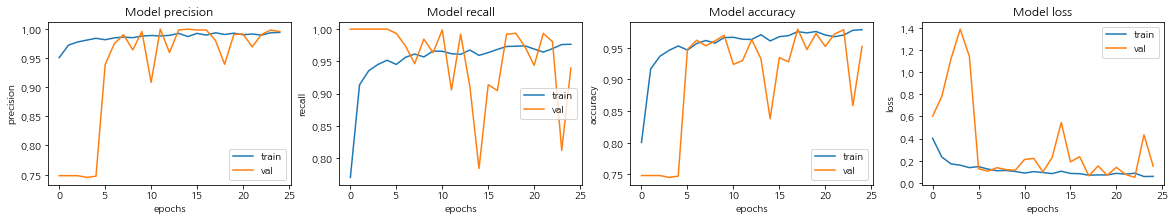

In [32]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])


## 모델 평가를 위해 loss, accuracy, precision, recall 값을 출력 

In [33]:
loss, acc, prec, rec = model.evaluate(test_ds)

20/20 [==============================] - 5s 230ms/step - loss: 0.4616 - accuracy: 0.8750 - precision: 0.8529 - recall: 0.9667


평가문항    
상세기준


#### 1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었는가?   

- 모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였는가?

#### 2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었는가?    

- regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었는가?    

#### 3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었는가?    

- Accuracy 기준 85%에 도달하였는가?

accuracy평가지표는 '환자가 폐렴에 걸렸는지?', 아니면 '폐렴에 안결렸는지' 파악하는 값으로 중요할것이다. 허나 우리는 폐렴인 사람을 폐렴이 아니라고 예측한다면 엄청난 리스크를 가져올것이다. 이부분에서 우리는 정확도보다는 recall의 값을 더 주의깊게 봐야할것이다.